In [1]:
### The purpose of this notebook is to test all the utilities of the RRT and RRT* algorithm: 

# Import libraries:
import numpy as np
import time
from A_star_Dijkstra_utilities import *
import importlib
from matplotlib import pyplot as plt
%matplotlib inline


import params

importlib.reload(params)

# Generate grid and return X and Y co-ordinates of all the nodes:
[params.X,params.Y] = generate_grid()


In [2]:
### The different classes used in the implementation: 

# 1. Class to model the nodes in the Tree: 

class Node:
    """
    Parameters are: 
    1. x - X co-ordinate of the node
    2. y - Y co-ordinate of the node
    3. parent - parent of the node in the Tree
    """
    
    x = 0.0
    y = 0.0
    parent = None
    cost = 0.0   # Used only in RRT*
    
    def __init__(self, xcoord, ycoord):
        self.x = xcoord
        self.y = ycoord



In [13]:
### 1. Function to compute orientation and checkIntersection:
### Thought I didn't need these! But guess I do!!! TESTED AND VERIFIED!

def get_orientation(pa,pb,pc):
    #All creidts to Savio
    #To help with the collsion checker

    # Compute the determinant:
    det = (pb[0] - pa[0])*(pc[1] - pa[1]) -  (pc[0] - pa[0])*(pb[1] - pa[1])

    # Determine orientation:
    # Case : Point is to the right -> Triplet is clockwise:
    if det > 0:
        return 1
    # Case : Point is to the left -> Triplet is counter-clockwise:
    elif det < 0:
        return 2

    # Case: Points are collinear:
    else:
        return 0
    
    

def checkIntersect_rrt(n1, n2):
    #All credits to Savio
    # To check if intersections occur

    p1 = [n1.x, n1.y]
    q1 = [n2.x, n2.y]
    
    for mazeSeg in params.infMazeSegments:
        
        p2 = mazeSeg[0]
        q2 = mazeSeg[1]

        p1q1p2 = get_orientation(p1, q1, p2)
        p1q1q2 = get_orientation(p1, q1, q2)
        p2q2p1 = get_orientation(p2, q2, p1)
        p2q2q1 = get_orientation(p2, q2, q1)

        # Check
        if p1q1p2 != p1q1q2 and p2q2p1 != p2q2q1:
            return True
        if p1q1p2 == 0 and p1q1q2==0 and p2q2p1 ==0  and p2q2q1 ==0:
            return True

    # Otherwise they don't intersect:
    return False


In [3]:
### 2. Function to step from nearest neighbor to randomly sampled node: 
def step_from_to(n1,n2):
    
    # Objetcive: Step from n1 to n2 as far as you can before collision occurs:

    res = Node(n1.x,n1.y)
    
    slope = math.atan2((n2.y - n1.y), (n2.x - n1.x))
    
    cSlope = math.cos(slope)
    sSlope = math.sin(slope)
    
    temp = Node(n1.x + params.stepSize*cSlope, n1.y + params.stepSize*sSlope)
    
    
    # Keep stepping until a collision occurs:
    while not checkIntersect_rrt(n1, temp):
        
        # Store the previous location: 
        res.x =  temp.x
        res.y =  temp.y
        
        # Step forward:
        temp.x += params.stepSize*cSlope
        temp.y += params.stepSize*sSlope

    return res

In [5]:
### 3. Function to extract shortest path from the Tree: 
def getShortestPath(start , goal): 
    
    # Initialize the path: 
    path = []
    
    # Set the currNode as the goal: 
    currNode = goal
    
    # Until we reach the start node:
    while currNode != start: 
        
        # Append the current node to the path: 
        path.append(currNode)
        
        # Move on to the next node which will be the parent of the current node: 
        currNode = currNode.parent
        
        
    return path    
        
    
    

In [ ]:
### 4. Function to perfrom collision checks for all segments and for all points on the Tree in a vectorized manner: TESTED AND VERIFIED!

# This is the core of the vectorization routine: 

def checkCollisionVect(nPts, rand):

    # Parameters needed: 
    # 1. Number of Segments - nSeg
    # 2. Number of Points already in the Tree - nPts
    nSeg = params.nSeg


    # Logic: For each point and for each segment, use the checkIntersect function which in turn uses the get_orientstion 
    # function. Break these two down in order to vectorize

    ## Steps: 

    # 1. We need a matrix of values giving the orientation of the different combinations
    #    The shape of this matrix is (nPts, nSeg). 
    #    Notation: p - Point on the tree ( Thus pxVec and pyVec need to be column vectors of x and y co-ods of the pts on the tree. Each has shape (nPts,1))
    #              q - Randomly sampled point. (qxSc and qySc are scalars)
    #              m - Start points of the segments - (mxVec and myVec are row vectors of x and y co-ods of the Start pts of the segments). Each has shape (1,nSeg)
    #              n - End points of the segments   - (nxVec and nyVec are rwo vectors of x and y co-ods of the End pts of the segments in). Each has shape (1,nSeg)

    # 2. Convert all the vectors and scalars to matrices of the appropriate shapes by using the boradcasting operation:

    shapingMat = np.zeros((nPts, nSeg))

    # For the points already on the tree:
    px = params.pxVec[:,np.newaxis] + shapingMat

    py = params.pyVec[:,np.newaxis] + shapingMat

    # For the randomly sampled point: 
    qx = rand.x + shapingMat

    qy = rand.y + shapingMat

    # For the start points of the segments: 
    mx = params.mxVec + shapingMat

    my = params.myVec + shapingMat

    # For the end points of the segments: 
    nx = params.nxVec + shapingMat

    ny = params.nyVec + shapingMat


    # 3. Compute the four orientation combinations in  vectorized manner: 

    # Reference formula for orientation of a triplet of points: ( uno, dos, tres) 

    #  det = (dos.x - uno.x)*(tres.y - uno.y) -  (tres.x - uno.x)*(dos.y - uno.y)

    # The 4 combinations are: 

    # 3.1: pqm ->  p = uno , q = dos , m = tres : Shape of pqm -(nPts, nSeg)

    pqm = np.sign( ( qx - px)*(my - py) - (mx - px)*(qy - py) )  

    # 3.2: pqn ->  p = uno , q = dos , n = tres : Shape of pqm -(nPts, nSeg)

    pqn = np.sign( ( qx - px)*(ny - py) - (nx - px)*(qy - py) ) 

    # 3.3: mnp -> m = uno , n = dos , p = tres : Shape of mnp - (nPts,nSeg)

    mnp = np.sign( (nx - mx)*(py - my)  - (px - mx)*(ny - my) )

    # 3.4: mnq -> m = uno , n = dos , q = tres : Shape of mnq - (nPts,nSeg)

    mnq = np.sign( (nx - mx)*(qy - my)  - (qx - mx)*(ny - my) )


    # 4. Check the two cases of intersection: 

    # 4.1: General case: Case 1: 
    case1 = np.logical_and(pqm != pqn , mnp != mnq)

    # 4.2: Special case: Case 2: This happens if the segments are collinear:
    case2 = np.logical_and( np.logical_and(pqm == 0 , pqn ==0) , np.logical_and( mnp ==0 , mnq ==0) )


    # A collision occurs if either of the two cases are True: 
    # If a collision occurs between a particular point and segment , it will appear as a True element at the [i,j] th 
    # element of collisionMat  - i -> For point on the tree , j -> For segment in the Maze
    collisionMat = np.logical_or(case1,case2)
    
    return collisionMat

In [9]:
### 5. Function to inflate the maze segments: TESTED AND VERIFIED!
def inflate_segments(): 
    
    segWidth = params.robotWidth
    
    # Loop throught the maze segments: 
    for mazeSeg in params.mazeSegments: 
        
        # Get the start and end points of the maze segment: Each point is a tuple of (x,y) co-ods
        sPoint = mazeSeg[0]
        ePoint = mazeSeg[1]
        
        # Determine the orientation of the maze segment: 
        orientSeg = -np.arctan2( (ePoint[1] - sPoint[1]) , (ePoint[0] - sPoint[0]))
        
        # Determine the increments in x and y co-ods that need to be added to the segment end points: 
        deltaX = np.sin(orientSeg)*segWidth
        deltaY = np.cos(orientSeg)*segWidth
        
        
        # Determine the 4 new points of the inflated obstacle: 
        sLeft  = ( sPoint[0] - deltaX , sPoint[1] - deltaY)
        sRight = ( sPoint[0] + deltaX , sPoint[1] + deltaY)
        eLeft  = ( ePoint[0] - deltaX , ePoint[1] - deltaY)
        eRight = ( ePoint[0] + deltaX , ePoint[1] + deltaY)
        
        # Determine the 4 new segments: 
        seg1 = [sLeft, eLeft]
        seg2 = [eLeft, eRight]
        seg3 = [eRight, sRight]
        seg4 = [sRight, sLeft]
        
        # Remove the old segment: 
        #params.mazeSegments.remove(mazeSeg)
        
        # Append the 4 new segments: 
        params.infMazeSegments.append(seg1)
        params.infMazeSegments.append(seg2)
        params.infMazeSegments.append(seg3)
        params.infMazeSegments.append(seg4)
        
        
    # Update the number of segments: 
    params.nSeg = len(params.infMazeSegments)
        
        
    return 
        
        
        

In [40]:
### 6. Function to extract path indices from a reversed list of path nodes: TESTED AND VERIFIED!

# Returns a list of tuples. Each tuple contains the (x,y) co-ods of the points in the path from start to goal:
def reverse_path(RRT_path): 
    
    path = []
    
    for node in reversed(RRT_path): 
        
        path.append((node.x , node.y))
        
    return path
    
    

In [16]:
### 7. Utility function to setup the vectorization: Ideally should be run only once:
def setup_vec(): 
    
    mxVec , myVec , nxVec , nyVec = [] ,[] ,[] ,[]
    
    for mazeSeg in params.infMazeSegments: 

        #  The x and y co-ods of the start points of all segments
        params.mxVec.append(mazeSeg[0][0])
        params.myVec.append(mazeSeg[0][1])

        #  The x and y co-ods of the end points of all segments
        params.nxVec.append(mazeSeg[1][0])
        params.nyVec.append(mazeSeg[1][1])         
        
    
    params.mxVec = np.array(mxVec) 
    params.myVec = np.array(myVec) 
    params.nxVec = np.array(nxVec) 
    params.nyVec = np.array(nyVec)
    
    return 

In [ ]:
### 8. Function to implement the RRT algorithm: The main function: 

# The functions returns a list with the path of nodes to be followed from Goal to Start: 

def RRT(start, goal):     
    
    # Append the start node to the list of nodes: 
    params.nodes.apppend(start)
    
    # Add the x and y co-ods of the start node to the co-od arrays: pxVec and pyVec: 
    params.pxVec = np.append(params.pxVec, start.x)
    params.pyVec = np.append(params.pyVec, start.y)
    
    # Initialize a flag to check whether goal has been reached: 
    reachedGoal = False
    
    # Keep count of the number of nodes: 
    nNodes = 1
    
    # Loop until we reach the goal or exceed the specifiecd number of nodes: 
    while not reachedGoal and nNodes < params.numNodes: 
        
        # Randomly sample a node within the specified window: 
        rand = Node(random.random()*params.windowSize, random.random()*params.windowSize)
        
        # Compute the distance of all nodes in the Tree to the random node: 
        distArr = np.sqrt((params.pyVec - rand.y)**2 , (params.pxVec - rand.x)**2) 
        
        # Obtain the Collision matrix here: 
        collisionMat = checkCollisionVect(nNodes, rand)
        
        # Extract the collision array : Which is collision status for each node in the tree: 
        collisionArr = np.any(collisionMat , axis =1)
        
        # Check the two cases: 
        
        # Case A: The paths from random node to all nodes on the tree have collisions:
        if np.all(collisionArr):
            
            # Find the nearest neighbor of the random node in the tree:
            nn = params.nodes[np.argmin(distArr)]
            
            # Step from the nearest neighbor to the random node: a.k.a Growing the tree: 
            rand = step_from_to(nn, rand)
            
        # Case B: At least one path from the random node to the nodes on the tree is collision free: 
        else: 
            
            # Find the indices of the nodes on the tree which don't have collisions:
            idxNoCollision = np.where(~collisionArr)[0]
            
            # Find the nearest neighbor among the collision free nodes: 
            nn = params.nodes[ np.argmin(distArr[idxNoCollision])]
            
        
        # No motion case: Not really understood this: Ask Bijo about this one. He knows this algorithm much better. 
        if rand.x == nn.x and rand.y == nn.y:            
            continue
            
            
        # Set the nearest neighbor as the parent of the random node: 
        rand.parent = nn
        
        # Add the random node to the Tree: 
        params.nodes.append(rand)
        params.pxVec = np.append(params.pxVec, rand.x)
        params.pyVec = np.append(params.pyVec, rand.y)
        
        # Increment the number of nodes: 
        nNodes += 1
            
        # The loop breaking condition: Checking if Goal can be reached: Done after every 'GG' nodes added to Tree: 
        
        if nNodes % params.GG == 0: 
            
            # Obtain the Collision matrix here: 
            collisionMat = checkCollisionVect(nNodes, goal)

            # Extract the collision array : Which is collision status for each node in the tree: 
            collisionArr = np.any(collisionMat , axis =1)
            
            # If at least one node can be connected with the goal:
            if not np.all(collisionArr):
                
                # Find the indices of the nodes on the tree which don't have collisions:
                idxNoCollision = np.where(~collisionArr)[0]

                # Find the nearest neighbor among the collision free nodes: 
                nn = nodes[ np.argmin(distArr[idxNoCollision])]
                
                # Set the nearest neighbor as the parent of the goal node: 
                goal.parent = nn
                
                # Extract the "shortest" path from the Tree: 
                RRT_path = getShortestPath(start, goal)
                
                # Toggle the flag for indicating that we reached the goal: This is kind of redundant. But still ask
                # Bijo before removing this...
                reachedGoal = True
                
                return RRT_path             
                
    
    # If the number of nodes is exceeded then return with failure: 
    print (" RRT failed to find a path")
    return []

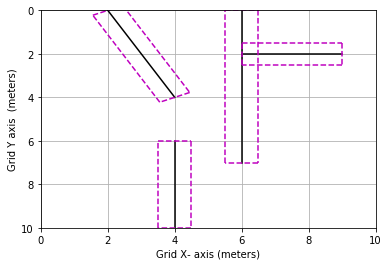

In [12]:
### Test out the inflate segments utility: 

# Start by plotting the original maze segments: 
for mazeSeg in params.mazeSegments: 
    
    plt.plot([mazeSeg[0][0], mazeSeg[1][0]], [mazeSeg[0][1] , mazeSeg[1][1]],'-k')

plt.xlim(0, params.widthX )
plt.ylim(0, params.widthY )
plt.grid()
plt.gca().invert_yaxis()

plt.xlabel('Grid X- axis (meters)')
plt.ylabel('Grid Y axis  (meters)')  
    
# # Now inflate the maze segments: 
inflate_segments()


# Now replot the new maze segments in a different color: 
for mazeSeg in params.infMazeSegments: 
    
    plt.plot([mazeSeg[0][0], mazeSeg[1][0]], [mazeSeg[0][1] , mazeSeg[1][1]],'--m')


In [41]:
### Test the function to reverse the path: 

RRT_path = []

for i in range(5): 
    
    RRT_path.append(Node(i,2*i))

    
# Use the function: 
revPath = reverse_path(RRT_path)


print(revPath)
    

[(4, 8), (3, 6), (2, 4), (1, 2), (0, 0)]


In [1]:
### ---------------------  RRT* utilities begin here --------------------- ###

In [2]:
# 1. Function to rewire the Tree: 

def rewire(rand, idxNoCollision , idxParent):     
    """
    
    Logic: For each node in the Tree (except for the parent of rand node) , check whether it is shorter to reach 
    given node through rand node rather than through its original parent. 
    
    Inputs: 
    1. rand - Randomly sampled node which has been added to the tree
    2. idxNoCollision - Indices of nodes in the Tree which do NOT cause collision with rand
    3. idxParent - Index of the parent node of rand in the Tree
    
    """
    
    # Loop through the nodes in the Tree which don't cause collision with the rand node: 
    for idx in idxNoCollision:
        
        
        # Compute the new cost: 
        newCost = rand.cost + distArr[idxNoCollision[idx]] 
        
        # Check whether it is shorter to reach there through the rand node: Except for rand parent node 
        if newCost < params.node[idx].cost and idx!= idxParent: 
            
            # Change the parent of the current node to rand: 
            params.node[idx].parent = rand
        
            # Update the cost of the current node: 
            params.node[idx].cost = newCost
            
            
    return           

In [1]:
# 2. Function to choose parent:

def choose_parent(rand, nNodes): 
    
    """
    
    Description: This function takes in the randomly sampled node and chooses the right parent for it
    
    Inputs: 
    1. rand  -  The randomly sampled node  
    2. nNodes - The number of nodes currently in the Tree
    
    
    #Special Case: The new random node collides with all the nodes on the tree. In this case grow the tree from the nearest neighbor 
    towards the random node. Set the collision node as the random node 
    
    Add the random node to the tree by choosing the right parent. The right parent is the one which minimizes the
    total cost-to-come
    
    
    """
    
    # 0. Compute the distance of all nodes in the Tree to the random node: 
    distArr = np.sqrt((params.pyVec - rand.y)**2 , (params.pxVec - rand.x)**2) 
    
    # 1. Obtain the Collision matrix for the random node w.r.t all nodes and all segments 
    collisionMat = checkCollisionVect(nNodes, rand)
    
    
    # 2. Find the nodes which don't cause collision with any of the segments: 
    collisionArr = np.any(collisionMat , axis =1)
    
    # 3. Address the special case: If all the nodes cause collision :-(
    if np.all(collisionArr):
        
        # Then step from nearest neighbor towards rand until collision:
        
        # Find the nearest neighbor of the random node in the tree:
        nn = params.nodes[np.argmin(distArr)]  # distArr does not exist yet. 
            
        # Step from the nearest neighbor to the random node: a.k.a Growing the tree: 
        rand = step_from_to(nn, rand)
        
    # 4. Now find the right parent for the random node: 
    # Among the non-colliding nodes find the one with minimum: cost-to-come + distance to rand: 
    
    # Find the indices of the nodes on the tree which don't have collisions:
    idxNoCollision = np.where(~collisionArr)[0]
    
    # Compute the total cost-to-come for all non-colliding nodes:
    totalCostToCome = params.pCost[idxNoCollision] +  distArr[idxNoCollision]
    
    # Find the one that minimzes the total cost-to-go and select it as the parent: 
    idxMin = np.argmin(totalCostToCome)
    idxParent = idxNoCollision[idxMin]   # This will be used in re-wiring step
    rand.parent = params.nodes[idxParent]
   
    
    # Add the total cost-to-come for the random node:
    rand.cost = totalCostToCome[idxMin]
    
    # Append the random node to the Tree: 
    params.nodes.append(rand)
    params.pxVec = np.append(params.pxVec, rand.x)
    params.pyVec = np.append(params.pyVec, rand.y)
    params.pCost = np.append(params.pCost, rand.cost)
    
    # Increment the number of nodes: 
    nNodes += 1
    
    # Return out the new random node
    # Return out the indices where collision does not occur (idxNoCollision). We will use them in the re-wire function
    # Return out the index of the parent of rand
    return rand, idxNoCollision , idxParent, nNodes
    
    

In [ ]:
### 3. RRT* Main routine: 

def RRT_star(start, goal):     
    
    # Append the start node to the list of nodes: 
    params.nodes.apppend(start)
    
    # Add the x and y co-ods of the start node to the co-od arrays: pxVec and pyVec: 
    params.pxVec = np.append(params.pxVec, start.x)
    params.pyVec = np.append(params.pyVec, start.y)
    
    # Initialize a flag to check whether goal has been reached: 
    reachedGoal = False
    
    # Keep count of the number of nodes: 
    nNodes = 1
    
    # Loop until we reach the goal or exceed the specifiecd number of nodes: 
    while not reachedGoal and nNodes < params.numNodes: 
        
        # Randomly sample a node within the specified window: 
        rand = Node(random.random()*params.windowSize, random.random()*params.windowSize)
        
        
        # Choose the right parent: 
        rand, idxNoCollision, idxParent , nNodes = choose_parent(rand, nNodes)
        
        # Re-wire the Tree: 
        rewire(rand, idxNoCollision, idxParent)
        
        # The loop breaking condition: Checking if Goal can be reached: Done after every 'GG' nodes added to Tree: 
        
        if nNodes % params.GG == 0: 
            
            # Obtain the Collision matrix here: Note: This is for each node with respect to the goal
            collisionMat = checkCollisionVect(nNodes, goal)

            # Extract the collision array : Which is collision status for each node in the tree: 
            collisionArr = np.any(collisionMat , axis =1)
            
            # If at least one node can be connected with the goal:
            if not np.all(collisionArr):
                
                # Find the indices of the nodes on the tree which don't have collisions:
                idxNoCollision = np.where(~collisionArr)[0]

                # Find the nearest neighbor among the collision free nodes: 
                nn = nodes[ np.argmin(distArr[idxNoCollision])]
                
                # Set the nearest neighbor as the parent of the goal node: 
                goal.parent = nn
                
                # Extract the "shortest" path from the Tree: 
                RRT_star_path = getShortestPath(start, goal)
                
                # Toggle the flag for indicating that we reached the goal: This is kind of redundant. But still ask
                # Bijo before removing this...
                reachedGoal = True
                
                return RRT_star_path             
                
    
    # If the number of nodes is exceeded then return with failure: 
    print (" RRT* failed to find a path")
    return []
        
        
        
        
